### Lab 3 Task 3

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chechelyk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\chechelyk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Пристрій: cuda
Розмір словника: 20000

Random Embeddings
Epoch 1/5 | train_loss=0.5012 | val_loss=0.4281 | val_acc=0.81
Epoch 2/5 | train_loss=0.3485 | val_loss=0.3736 | val_acc=0.84
Epoch 3/5 | train_loss=0.2649 | val_loss=0.3425 | val_acc=0.86
Epoch 4/5 | train_loss=0.2257 | val_loss=0.3932 | val_acc=0.84
Epoch 5/5 | train_loss=0.2108 | val_loss=0.3874 | val_acc=0.85
Результат: acc=86.52%

GloVe Embeddings
Завантажено векторів: 400000
Покриття: 19559/20000 = 97.8%
Epoch 1/5 | train_loss=0.4377 | val_loss=0.3744 | val_acc=0.83
Epoch 2/5 | train_loss=0.2900 | val_loss=0.3082 | val_acc=0.88
Epoch 3/5 | train_loss=0.2005 | val_loss=0.3208 | val_acc=0.87
Epoch 4/5 | train_loss=0.1340 | val_loss=0.3017 | val_acc=0.89
Epoch 5/5 | train_loss=0.0914 | val_loss=0.3430 | val_acc=0.88
Результат: acc=89.60%


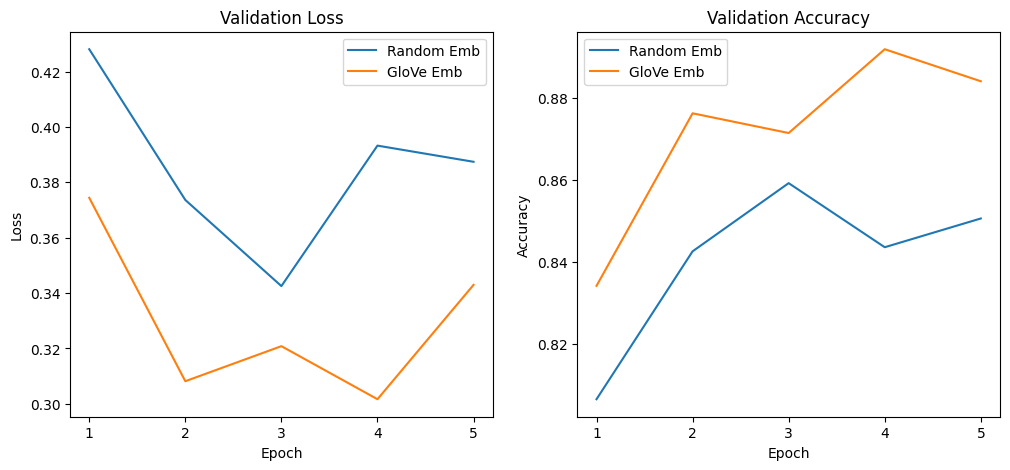

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import os
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('punkt_tab')

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Пристрій: {device}")

# Завантаження та обробка даних
train_df = pd.read_csv('../data/train.csv', header=None, names=['label', 'title', 'text'])
test_df = pd.read_csv('../data/test.csv', header=None, names=['label', 'title', 'text'])

train_df['full_text'] = train_df['title'].astype(str) + " " + train_df['text'].astype(str)
test_df['full_text'] = test_df['title'].astype(str) + " " + test_df['text'].astype(str)

train_df['label'] = train_df['label'].apply(lambda x: 0 if x == 1 else 1)
test_df['label'] = test_df['label'].apply(lambda x: 0 if x == 1 else 1)

train_df = train_df.sample(n=25000, random_state=42)
test_df = test_df.sample(n=5000, random_state=42)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"@\S+", " ", text)
    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"<.*?>", " ", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text

# Токенізація
cleaned_texts = [clean_text(t) for t in train_df['full_text']]
tokens = [word_tokenize(t) for t in cleaned_texts]

counter = Counter()
for tok_list in tokens:
    counter.update(tok_list)

specials = ["[PAD]", "[UNK]"]
most_common = counter.most_common(20000 - len(specials))

itos = specials + [w for w, _ in most_common]
stoi = {w: i for i, w in enumerate(itos)}

vocab_size = len(stoi)
print(f"Розмір словника: {vocab_size}")

def encode(token_list):
    return [stoi.get(t, stoi["[UNK]"]) for t in token_list]

encoded_texts = [encode(t) for t in tokens]

def pad_sequence(seq):
    if len(seq) > 150:
        return torch.tensor(seq[:150], dtype=torch.long)
    else:
        return torch.tensor(seq + [stoi["[PAD]"]] * (150 - len(seq)), dtype=torch.long)

X = torch.stack([pad_sequence(seq) for seq in encoded_texts])
y = torch.tensor(train_df['label'].values, dtype=torch.float32)

cleaned_test = [clean_text(t) for t in test_df['full_text']]
tokens_test = [word_tokenize(t) for t in cleaned_test]
encoded_test = [encode(t) for t in tokens_test]

X_test = torch.stack([pad_sequence(seq) for seq in encoded_test])
y_test = torch.tensor(test_df['label'].values, dtype=torch.float32)

dataset = TensorDataset(X, y)
val_sz = int(len(dataset) * 0.2)
train_sz = len(dataset) - val_sz
train_ds, val_ds = random_split(dataset, [train_sz, val_sz], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64)

test_ds = TensorDataset(X_test, y_test)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False)

class BiLSTM_Classifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, pad_idx, num_layers=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        
        self.lstm = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=0.5 if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x):
        x = self.embedding(x)
        out, (h, c) = self.lstm(x)
        h_fwd = h[-2, :, :]
        h_bwd = h[-1, :, :]
        h_cat = torch.cat([h_fwd, h_bwd], dim=1)
        logits = self.fc(h_cat)
        return logits.squeeze(1)

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    train_loss = 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(loader)

def evaluate_one_epoch(model, loader, criterion, device):
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            valid_loss += loss.item()
    return valid_loss / len(loader)

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, total_acc, n = 0.0, 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)
        preds = (torch.sigmoid(logits) >= 0.5).long()
        total_loss += loss.item() * xb.size(0)
        total_acc  += (preds == yb.long()).sum().item()
        n += xb.size(0)
    return total_loss/n, total_acc/n

n_epochs = 5

# а) Random Embeddings
print("\nRandom Embeddings")
model_basic = BiLSTM_Classifier(vocab_size, 100, 64, stoi["[PAD]"]).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_basic.parameters(), lr=1e-3)

history_a = {'val_loss': [], 'val_acc': []}
best_valid_loss_a = float('inf')

for epoch in range(n_epochs):
    train_loss = train_one_epoch(model_basic, train_loader, optimizer, criterion, device)
    val_loss = evaluate_one_epoch(model_basic, val_loader, criterion, device)
    
    _, val_acc = evaluate(model_basic, val_loader, criterion, device)
    history_a['val_loss'].append(val_loss)
    history_a['val_acc'].append(val_acc)
    
    if val_loss < best_valid_loss_a:
        best_valid_loss_a = val_loss
        torch.save(model_basic.state_dict(), 'best_model_random.pth')
    
    print(f"Epoch {epoch+1}/{n_epochs} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_acc={val_acc:.2f}")

model_basic.load_state_dict(torch.load('best_model_random.pth'))
test_loss_a, test_acc_a = evaluate(model_basic, test_loader, criterion, device)
print(f"Результат: acc={test_acc_a*100:.2f}%")

# б) GloVe Embeddings
print("\nGloVe Embeddings")

glove_path = "glove.6B.100d.txt"

def load_glove_txt(path):
    vectors = {}
    with open(path, "r", encoding="utf8") as f:
        for line in f:
            parts = line.rstrip().split(" ")
            word = parts[0]
            vec = np.asarray(parts[1:], dtype=np.float32)
            vectors[word] = vec
    return vectors

if os.path.exists(glove_path):
    glove = load_glove_txt(glove_path)
    print(f"Завантажено векторів: {len(glove)}")

    emb_matrix = np.zeros((vocab_size, 100))
    hit = 0
    for w, idx in stoi.items():
        v = glove.get(w)
        if v is not None:
            emb_matrix[idx] = v
            hit += 1
        else:
            emb_matrix[idx] = np.random.normal(scale=0.6, size=(100, ))
            
    print(f"Покриття: {hit}/{vocab_size} = {hit/vocab_size:.1%}")

    model_tl = BiLSTM_Classifier(vocab_size, 100, 64, stoi["[PAD]"]).to(device)
    
    model_tl.embedding.load_state_dict({'weight': torch.tensor(emb_matrix).float()})
    model_tl.embedding.weight.requires_grad = True 

    optimizer_tl = torch.optim.Adam(model_tl.parameters(), lr=1e-3)
    history_b = {'val_loss': [], 'val_acc': []}
    best_valid_loss_b = float('inf')

    for epoch in range(n_epochs):
        train_loss = train_one_epoch(model_tl, train_loader, optimizer_tl, criterion, device)
        val_loss = evaluate_one_epoch(model_tl, val_loader, criterion, device)
        
        _, val_acc = evaluate(model_tl, val_loader, criterion, device)
        history_b['val_loss'].append(val_loss)
        history_b['val_acc'].append(val_acc)

        if val_loss < best_valid_loss_b:
            best_valid_loss_b = val_loss
            torch.save(model_tl.state_dict(), 'best_model_glove.pth')
        
        print(f"Epoch {epoch+1}/{n_epochs} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_acc={val_acc:.2f}")

    model_tl.load_state_dict(torch.load('best_model_glove.pth'))
    test_loss_b, test_acc_b = evaluate(model_tl, test_loader, criterion, device)
    print(f"Результат: acc={test_acc_b*100:.2f}%")

    epochs_range = range(1, n_epochs + 1)
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history_a['val_loss'], label='Random Emb')
    plt.plot(epochs_range, history_b['val_loss'], label='GloVe Emb')
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(epochs_range)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history_a['val_acc'], label='Random Emb')
    plt.plot(epochs_range, history_b['val_acc'], label='GloVe Emb')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(epochs_range)
    plt.legend()
    
    plt.show()

else:
    print("Не вдалося знайти GloVe файл.")

Використання pretrained embeddings показало кращу точність на відміну від випалкової ініціалізації ваг, 89.60% проти 86.52% відповідно. Метрики зросли завдяки тому, що 97.8% слів словника вже мали попередньо навчені вектори з семантичним змістом. Навчання з GloVe відбувалося швидше та стабільніше: модель стартувала з менших втрат і до 5-ї епохи досягла train_loss=0.09, проти 0.21 у першому варіанті виконання, демонструючи значно кращу збіжність.